Using TensorFlow backend.


(50000, 28, 28) (50000,)


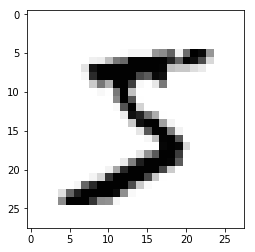

In [2]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [48]:
import tensorflow as tf
import numpy as np
import math
import time
from tensorflow.python.framework import ops

In [3]:
def convert_to_one_hot(labels, class_type):
    """
    Convert Y labels to one hot matrix.
    
    Arguments:
    labels -- vector contains the labels of mnist.
    class_type -- unique records of the label vector.
    
    Returns:
    one_hot -- one_hot_matrix of the label vector.
    """
    C = tf.constant(class_type, name = "C")
    one_hot_matrix = tf.one_hot(indices=labels, depth=C, axis=0)
    
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    
    return one_hot


In [4]:
# Reference: https://github.com/andersy005/deep-learning-specialization-coursera/blob/master/02-Improving-Deep-Neural-Networks/week3/Programming-Assignments/tf_utils.py
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [5]:
# Flatten dataset
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T
X_val_flatten = X_val.reshape(X_val.shape[0], -1).T
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T

# Normalization
X_train = X_train_flatten/255
X_val = X_val_flatten/255
X_test = X_test_flatten/255

# Convert training and test labels to one hot matrices
y_train = convert_to_one_hot(y_train, 10)
y_val = convert_to_one_hot(y_val, 10)
y_test = convert_to_one_hot(y_test, 10)

In [26]:
# Create placeholder function
def create_placeholder(image_size_flatten, class_type):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    image_size_flatten -- scalar, size of an image vector (num_px * num_px = 28 * 28 = 784)
    class_type -- scalar, number of classes (from 0 to 9, so -> 10)
    
    Returns:
    X -- placeholder for the data input, of shape [image_size_flatten, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [class_type, None] and dtype "float"
    keep_prob -- placeholder for dropout, dtype "float"
    """
    
    X = tf.placeholder(dtype = tf.float32, shape = [image_size_flatten, None], name = "x")
    Y = tf.placeholder(dtype = tf.float32, shape = [class_type, None], name = "y")
    keep_prob = tf.placeholder(dtype = tf.float32)
    
    return X, Y, keep_prob

In [7]:
# Initialize_parameters
def initialize_parameters(image_size_flatten, units_in_layers, class_type = 10):
    """
    Initializes parameters to build a neural network with tensorflow. 
    
    Arguments:
    image_size_flatten -- scalar, size of an image vector (num_px * num_px = 28 * 28 = 784)
    units_in_layers -- list, unit number in each hidden layer 
                       (dosen't contain the last hidden layer for classification, that layer will be appended in this function)
    class_type -- scalar, number of classes (from 0 to 9, so -> 10)
    
    Returns:
    parameters -- a dictionary contains all the weights "W" and bias term "b".
    """
    units_in_layers.append(class_type)
    layers_n = len(units_in_layers)
    units_in_layers.insert(0, image_size_flatten)
    parameters = {}
    
    for l in range(layers_n):
        parameters["W"+str(l+1)] = tf.get_variable("W"+str(l+1), [units_in_layers[l+1], units_in_layers[l]], initializer = tf.contrib.layers.xavier_initializer())
        parameters["b"+str(l+1)] = tf.get_variable("b"+str(l+1), [units_in_layers[l+1], 1], initializer = tf.zeros_initializer())
        
    return parameters

In [27]:
# Forward propagation
def forward_propagation(X, parameters, keep_prob):
    """
    Implements the forward propagation for the model.
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing parameters weights and bias for each layer.
                  the shapes are given in initialize_parameters
    keep_prob -- list, probability for each layer when you are using dropout.

    Returns:
    Z -- the output of the last LINEAR unit
    """
    A = X
    layers_n = len(parameters) // 2
    for l in range(layers_n-1):
        Z = tf.add(tf.matmul(parameters["W"+str(l+1)], A), parameters["b"+str(l+1)])
        A = tf.nn.relu(Z)
        A = tf.nn.dropout(A, keep_prob[l])
    Z = tf.add(tf.matmul(parameters["W"+str(layers_n)], A), parameters["b"+str(layers_n)])
    return Z


In [9]:
# Cost function
def compute_cost(Z, Y):
    """
    Computes the cost
    
    Arguments:
    Z -- output of forward propagation (output of the last LINEAR unit), of shape (10, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z
    
    Returns:
    cost - Tensor of the cost function
    """
    logits = tf.transpose(Z)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    return cost

In [60]:
# Create model
def model(X_train, y_train, X_val, y_val, X_test, y_test, learning_rate = 0.01, structure = [500],
          num_epochs = 25, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network.
    
    Arguments:
    X_train -- training set
    y_train -- training set
    X_val -- validation set
    y_val -- validation set
    X_test -- test set
    y_test -- test set
    learning_rate -- learning rate of the optimization
    structure -- list, the structure of your network, unit number in specific layer
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (image_size_flatten, m) = X_train.shape           # (image_size_flatten: input size, m : number of examples in the train set)
    class_type = y_train.shape[0]                     # class_type : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (image_size_flatten, class_type)
    X, Y, keep_prob = create_placeholder(image_size_flatten, class_type)

    # Initialize parameters
    parameters = initialize_parameters(image_size_flatten, structure, class_type = class_type)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z = forward_propagation(X, parameters, keep_prob)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        running_time = time.time()
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y,  keep_prob: [0.8]})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 2 == 0:
                spend = (time.time()-running_time)
                print ("Running: %i seconds | Cost after epoch %i: %f" % (spend, epoch, epoch_cost))
            if print_cost == True and epoch % 2 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: y_train, keep_prob: [1]}))
        print ("Validation Accuracy:", accuracy.eval({X: X_val, Y: y_val, keep_prob: [1]}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: y_test, keep_prob: [1]}))
        
        finish_time = (time.time() - running_time)
        print ("Running: %i seconds" % (finish_time))
        
        return parameters

Running: 11 seconds | Cost after epoch 0: 0.453075
Running: 34 seconds | Cost after epoch 2: 0.165637
Running: 58 seconds | Cost after epoch 4: 0.115791
Running: 81 seconds | Cost after epoch 6: 0.092891
Running: 103 seconds | Cost after epoch 8: 0.075716
Running: 127 seconds | Cost after epoch 10: 0.062346
Running: 150 seconds | Cost after epoch 12: 0.053950
Running: 173 seconds | Cost after epoch 14: 0.048848
Running: 196 seconds | Cost after epoch 16: 0.043296
Running: 219 seconds | Cost after epoch 18: 0.039123
Running: 241 seconds | Cost after epoch 20: 0.037975
Running: 264 seconds | Cost after epoch 22: 0.033462
Running: 288 seconds | Cost after epoch 24: 0.030813


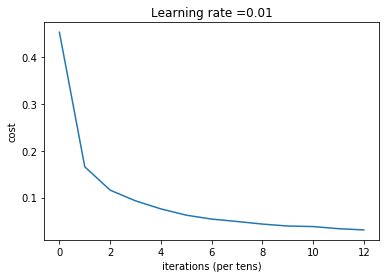

Parameters have been trained!
Train Accuracy: 0.99614
Validation Accuracy: 0.9803
Test Accuracy: 0.9804
Running: 292 seconds


In [61]:
parameters = model(X_train, y_train, X_val, y_val, X_test, y_test)